# Contamination Detector Module MVP

I have tried detecting potentially contaminated segments in our training data.

According to the seminar and project scope we have performed two main scopoes.
1. **Reference Benchmark Comparison:** Each segment is compared against a reference set (synthetic here) via semantic similarity.
2. **PaCoST-Inspired Confidence Testing:** For each segment, we generate a perturbed variant and compute model confidence (via perplexity) using a lightweight LM. A significant gap in confidence (lower perplexity on the original) indicates possible memorization or contamination.

In [1]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

# For timing and progress display
from tqdm.notebook import tqdm

## Loading the preprocessed data

In [2]:
data_file = os.path.join("../data", "preprocessed_wikitext103_subset.csv")
df = pd.read_csv(data_file, on_bad_lines='skip', engine='python')
print("Loaded data shape:", df.shape)
print("Sample rows:")
print(df.head())

Loaded data shape: (189700, 5)
Sample rows:
                                                text  text_length  \
0  = Valkyria Chronicles III =\nSenjō no Valkyria...        20297   
1  = Valkyria Chronicles III =\nSenjō no Valkyria...        20297   
2  = Valkyria Chronicles III =\nSenjō no Valkyria...        20297   
3  = Valkyria Chronicles III =\nSenjō no Valkyria...        20297   
4  = Valkyria Chronicles III =\nSenjō no Valkyria...        20297   

                                        cleaned_text  \
0  = valkyria chronicles iii = senj no valkyria 3...   
1  = valkyria chronicles iii = senj no valkyria 3...   
2  = valkyria chronicles iii = senj no valkyria 3...   
3  = valkyria chronicles iii = senj no valkyria 3...   
4  = valkyria chronicles iii = senj no valkyria 3...   

                                              tokens  \
0  ['=', 'Ġv', 'alky', 'ria', 'Ġchron', 'icles', ...   
1  ['=', 'Ġv', 'alky', 'ria', 'Ġchron', 'icles', ...   
2  ['=', 'Ġv', 'alky', 'ria', 'Ġchro

### Load/Define Reference Benchmark Data
For now, I am defining a small reference set, later I plan to add texts from projectGutenberg or alike.

In [3]:
reference_texts = [
    "this is a known contaminated text from benchmark dataset",
    "another reference text that should not be in the training data",
    "benchmark evaluation text that must remain separate"
]

# Load a SentenceTransformer model for computing embeddings
ref_model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for the reference texts
ref_embeddings = ref_model.encode(reference_texts, convert_to_tensor=True)

## Define Functions for reference comparison

a function that computes maximum cosine similarity between a given segment and the reference texts. If the similarity exceeds a threshold (e.g., 0.9), we flag the segment as potentially contaminated by reference overlap.

In [4]:
def check_reference_similarity(segment, ref_embeddings, threshold=0.9):
    # Compute embedding for the segment
    segment_embedding = ref_model.encode(segment, convert_to_tensor=True)
    # Compute cosine similarities with each reference embedding
    cos_scores = util.cos_sim(segment_embedding, ref_embeddings)
    max_sim = cos_scores.max().item()
    flag = max_sim >= threshold
    return max_sim, flag

## Confidence Testing(PaCoST-Inspired)

**Perturbation Function:** We define a simple perturbation function that shuffles the words in the segment. (In practice, you might use more advanced paraphrasing techniques.)

**Perplexity Calculation:** We use a lightweight LM (DistilGPT-2) to compute the perplexity of a text. Lower perplexity indicates higher confidence.

**Note:** Perplexity is computed as the exponential of the loss from the model. I have used small batch size for avoiding memory issues as most of the code is working locally.


In [5]:
def perturb_text(text):
    words = text.split()
    if len(words) <= 1:
        return text  # No perturbation possible for single-word texts
    random.shuffle(words)
    return " ".join(words)

# Load a lightweight LM for perplexity calculation
lm_model_name = "distilgpt2"  # a lightweight model
lm_model = AutoModelForCausalLM.from_pretrained(lm_model_name)
lm_tokenizer = AutoTokenizer.from_pretrained(lm_model_name)
lm_model.eval()
if torch.mps.is_available():
    lm_model.to("mps")

def compute_perplexity(text, model, tokenizer):
    # Encode the text and compute loss (per-token)
    encodings = tokenizer(text, return_tensors='pt')
    # if torch.cuda.is_available():
    #     encodings = {k: v.to("cuda") for k, v in encodings.items()}
    if torch.mps.is_available():
        encodings = {k: v.to("mps") for k, v in encodings.items()}
        # print("mps available")
    with torch.no_grad():
        outputs = model(**encodings, labels=encodings["input_ids"])
    loss = outputs.loss
    perplexity = torch.exp(loss)
    return perplexity.item()

## Contamination detection on a Batch of Segments

processing the data in batches:
1. Check reference similarity
2. Compute perplexity for the original segment.
3. Generate a perturbed version and compute its perplexity.
4. Flag the segment if:
    - The max reference similarity is above a threshold (0.8), OR
    - The original perplexity is significantly lower than the perturbed perplexity
- **Simple Ration Test:** if perplexity(original) < 0.8 * perplexity(perturbed), I flag it.

In [6]:
# sample_df = df.sample(n=1000, random_state=42).copy()
sample_df = df.copy() # testing for complete dataset
# lists to hold the results
ref_similarities = []
ref_flags = []
perplexity_orig_list = []
perplexity_perturbed_list = []
confidence_flags = []

# threshold for perplexity ratio
perplexity_ratio_threshold = 0.8

In [7]:
# Process each segment in the sample
for seg in tqdm(sample_df['segments'].tolist(), desc="Processing segments"):
    # Reference similarity check
    max_sim, ref_flag = check_reference_similarity(seg, ref_embeddings, threshold=0.9)
    ref_similarities.append(max_sim)
    ref_flags.append(ref_flag)

    # Compute perplexity for original
    try:
        ppl_orig = compute_perplexity(seg, lm_model, lm_tokenizer)
    except Exception as e:
        ppl_orig = None
    # Generate perturbed version and compute perplexity
    perturbed_seg = perturb_text(seg)
    try:
        ppl_perturbed = compute_perplexity(perturbed_seg, lm_model, lm_tokenizer)
    except Exception as e:
        ppl_perturbed = None

    perplexity_orig_list.append(ppl_orig)
    perplexity_perturbed_list.append(ppl_perturbed)

    # Check if confidence gap flag condition is met (if both perplexities are computed)
    if (ppl_orig is not None and ppl_perturbed is not None and ppl_perturbed > 0):
        conf_flag = ppl_orig < perplexity_ratio_threshold * ppl_perturbed
    else:
        conf_flag = False
    confidence_flags.append(conf_flag)

# Add the results to the sample DataFrame
sample_df['ref_similarity'] = ref_similarities
sample_df['ref_flag'] = ref_flags
sample_df['ppl_original'] = perplexity_orig_list
sample_df['ppl_perturbed'] = perplexity_perturbed_list
sample_df['confidence_flag'] = confidence_flags

# Combine flags: flag if either reference flag or confidence flag is True
sample_df['contamination_flag'] = sample_df['ref_flag'] | sample_df['confidence_flag']

Processing segments:   0%|          | 0/189700 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
Token indices sequence length is longer than the specified maximum sequence length for this model (1246 > 1024). Running this sequence through the model will result in indexing errors


In [8]:
sample_df.head()

,text,text_length,cleaned_text,tokens,segments,ref_similarity,ref_flag,ppl_original,ppl_perturbed,confidence_flag,contamination_flag
0,= Valkyria Chronicles III =\nSenjō no Valkyria...,20297,= valkyria chronicles iii = senj no valkyria 3...,"['=', 'Ġv', 'alky', 'ria', 'Ġchron', 'icles', ...",= valkyria chronicles iii = senj no valkyria 3...,0.197435,False,178.504913,369.689667,True,True
1,= Valkyria Chronicles III =\nSenjō no Valkyria...,20297,= valkyria chronicles iii = senj no valkyria 3...,"['=', 'Ġv', 'alky', 'ria', 'Ġchron', 'icles', ...","valkyria of the battlefield 3), commonly refer...",0.131318,False,170.454163,1000.327271,True,True
2,= Valkyria Chronicles III =\nSenjō no Valkyria...,20297,= valkyria chronicles iii = senj no valkyria 3...,"['=', 'Ġv', 'alky', 'ria', 'Ġchron', 'icles', ...","released in january 2011 in japan, it is the t...",0.156899,False,41.388802,1023.383057,True,True
3,= Valkyria Chronicles III =\nSenjō no Valkyria...,20297,= valkyria chronicles iii = senj no valkyria 3...,"['=', 'Ġv', 'alky', 'ria', 'Ġchron', 'icles', ...",employing the same fusion of tactical and real...,0.157302,False,203.477921,2959.993652,True,True
4,= Valkyria Chronicles III =\nSenjō no Valkyria...,20297,= valkyria chronicles iii = senj no valkyria 3...,"['=', 'Ġv', 'alky', 'ria', 'Ġchron', 'icles', ...","the game began development in 2010, carrying o...",0.093961,False,118.153999,2026.916992,True,True


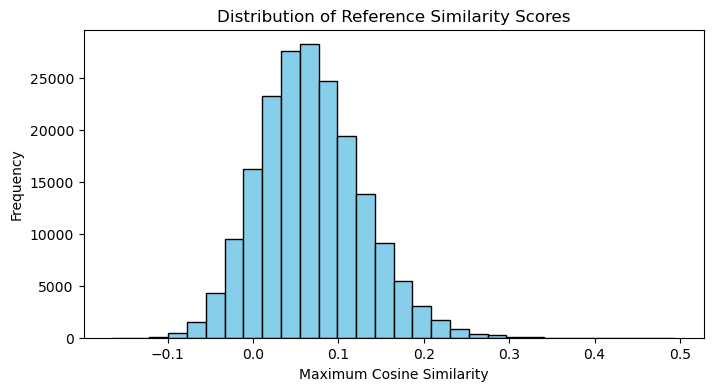

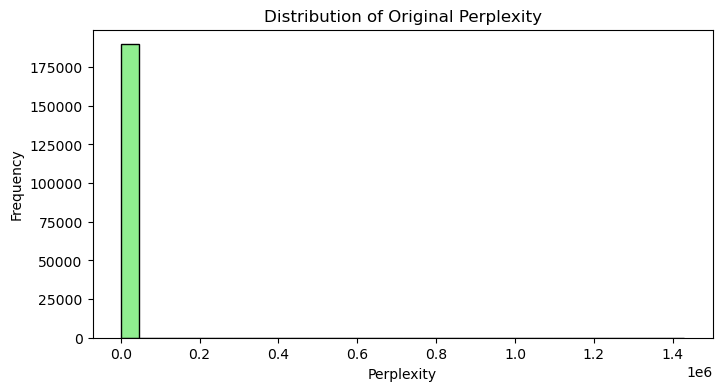

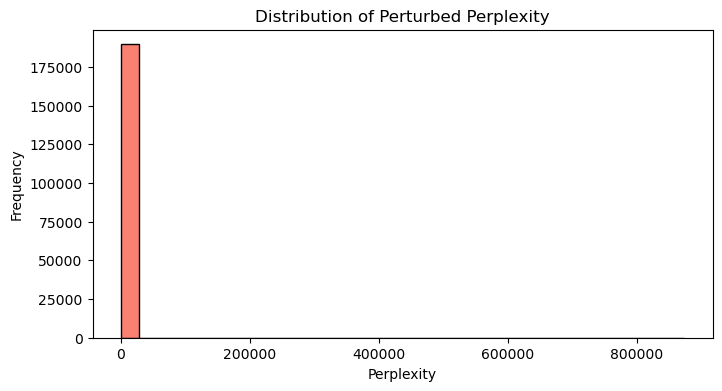

Number of flagged segments in the sample: 187327 / 189700


In [9]:
# Plot histogram of reference similarities
plt.figure(figsize=(8, 4))
plt.hist(ref_similarities, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Reference Similarity Scores")
plt.xlabel("Maximum Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

# Plot histogram of original perplexities
valid_ppl_orig = [p for p in perplexity_orig_list if p is not None]
plt.figure(figsize=(8, 4))
plt.hist(valid_ppl_orig, bins=30, color='lightgreen', edgecolor='black')
plt.title("Distribution of Original Perplexity")
plt.xlabel("Perplexity")
plt.ylabel("Frequency")
plt.show()

# Plot histogram of perturbed perplexities
valid_ppl_pert = [p for p in perplexity_perturbed_list if p is not None]
plt.figure(figsize=(8, 4))
plt.hist(valid_ppl_pert, bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Perturbed Perplexity")
plt.xlabel("Perplexity")
plt.ylabel("Frequency")
plt.show()

# Count and display flagged segments
num_flagged = sample_df['contamination_flag'].sum()
print(f"Number of flagged segments in the sample: {num_flagged} / {len(sample_df)}")

## Saving Flagged segments

summary stats and saving the flagged segments

In [10]:
# Count the number of flagged segments
num_flagged = sample_df['contamination_flag'].sum()
print(f"Number of flagged segments in the sample: {num_flagged} / {len(sample_df)}")

# Save the results for further inspection
output_dir = "../data"
os.makedirs(output_dir, exist_ok=True)
flagged_output_file = os.path.join(output_dir, "contamination_flags_sample.csv")
sample_df.to_csv(flagged_output_file, index=False)
print(f"Flagged segments saved to {flagged_output_file}")

Number of flagged segments in the sample: 187327 / 189700
Flagged segments saved to ../data/contamination_flags_sample.csv
